## Imports

In [1]:
import numpy as np
import pandas as pd

## Read in the Data

In [2]:
df = pd.read_csv("../DATA/moviereviews.csv")

In [3]:
df.head(10)

,label,review
0,neg,how do films like mouse hunt get into theatres...
1,neg,some talented actresses are blessed with a dem...
2,pos,this has been an extraordinary year for austra...
3,pos,according to hollywood movies made in last few...
4,neg,my first press screening of 1998 and already i...
5,neg,"to put it bluntly , ed wood would have been pr..."
6,neg,"synopsis : melissa , a mentally-disturbed woma..."
7,neg,tim robbins and martin lawernce team up in thi...
8,neg,"in "" gia "" , angelina jolie plays the titular ..."
9,neg,"in 1990 , the surprise success an unheralded l..."


## Check for NaN and Empty strings

In [4]:
df.isnull().sum()

label      0
review    35
dtype: int64

### Drop NaN

In [5]:
df = df.dropna()

In [6]:
df.isnull().sum()

label     0
review    0
dtype: int64

In [7]:
df[df["review"].str.isspace()]

,label,review
57,neg,
71,pos,
147,pos,
151,pos,
283,pos,
307,pos,
313,neg,
323,pos,
343,pos,
351,neg,


### Drop empty strings

In [8]:
df = df[~df["review"].str.isspace()]

## EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1938 non-null   object
 1   review  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


In [10]:
df["label"].value_counts()

label
neg    969
pos    969
Name: count, dtype: int64

## Check Top 20 Neg/Pos Words

In [14]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [12]:
vectorizer = CountVectorizer(stop_words="english")
matrix = vectorizer.fit_transform(df[df["label"] == "neg"]["review"])
freq = zip(vectorizer.get_feature_names_out(), matrix.sum(axis=0).tolist()[0])
print(sorted(freq, key=lambda x: -x[1])[:20])

[('film', 4063), ('movie', 3131), ('like', 1808), ('just', 1480), ('time', 1127), ('good', 1117), ('bad', 997), ('character', 926), ('story', 908), ('plot', 888), ('characters', 838), ('make', 813), ('really', 743), ('way', 734), ('little', 696), ('don', 683), ('does', 666), ('doesn', 648), ('action', 635), ('scene', 634)]


In [13]:
vectorizer = CountVectorizer(stop_words="english")
matrix = vectorizer.fit_transform(df[df["label"] == "pos"]["review"])
freq = zip(vectorizer.get_feature_names_out(), matrix.sum(axis=0).tolist()[0])
print(sorted(freq, key=lambda x: -x[1])[:20])

[('film', 5002), ('movie', 2389), ('like', 1721), ('just', 1273), ('story', 1199), ('good', 1193), ('time', 1175), ('character', 1037), ('life', 1032), ('characters', 957), ('way', 864), ('films', 851), ('does', 828), ('best', 788), ('people', 769), ('make', 764), ('little', 751), ('really', 731), ('man', 728), ('new', 702)]


## Train | Test Split

In [29]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [17]:
X = df["review"]
y = df["label"]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [19]:
tfidf = TfidfVectorizer(stop_words="english")
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Training and Choosing the Best Model

In [20]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [21]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter=10000)
log_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=10000)

In [22]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train_tfidf, y_train)

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

## Performance Evaluation

In [23]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [24]:
def report(model):
    predictions = model.predict(X_test_tfidf)
    print(classification_report(y_test, predictions))
    ConfusionMatrixDisplay.from_estimator(model, X_test_tfidf, y_test)

              precision    recall  f1-score   support

         neg       0.78      0.87      0.82       191
         pos       0.86      0.76      0.80       197

    accuracy                           0.81       388
   macro avg       0.82      0.81      0.81       388
weighted avg       0.82      0.81      0.81       388



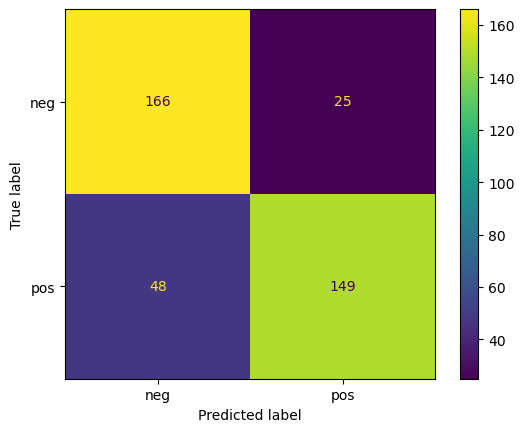

In [25]:
report(nb)

              precision    recall  f1-score   support

         neg       0.80      0.85      0.83       191
         pos       0.85      0.79      0.82       197

    accuracy                           0.82       388
   macro avg       0.82      0.82      0.82       388
weighted avg       0.82      0.82      0.82       388



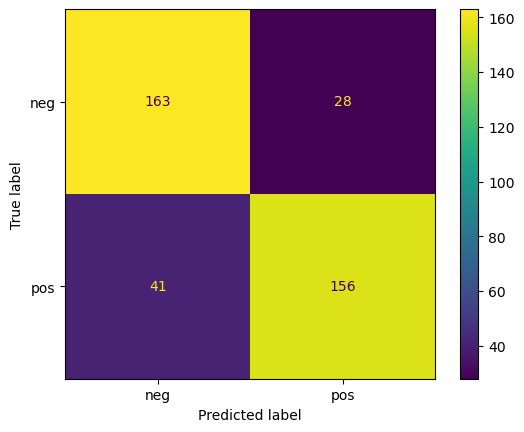

In [26]:
report(log_model)

              precision    recall  f1-score   support

         neg       0.81      0.84      0.82       191
         pos       0.84      0.81      0.82       197

    accuracy                           0.82       388
   macro avg       0.82      0.82      0.82       388
weighted avg       0.83      0.82      0.82       388



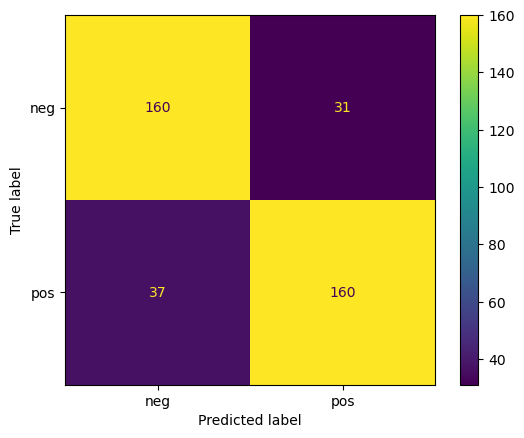

In [27]:
report(svc)

## Choose LinearSVC 
### Tune parameters using GridSearchCV


In [30]:
from sklearn.pipeline import Pipeline

In [31]:
pipe = Pipeline([("tfidf", TfidfVectorizer(stop_words="english")), ("svc", LinearSVC())])

In [32]:
penalty = ["l1", "l2"]
C = [0.01, 0.1, 0.5, 1, 2]

In [33]:
param_grid = {"svc__penalty": penalty, "svc__C": C}

In [34]:
model = GridSearchCV(pipe, param_grid)

### Train the entire data and deploy model

In [35]:
model.fit(X, y)

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\pc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\pc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\pc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\pc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: Futu

C:\Users\pc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\pc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\pc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\pc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\pc\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: Futu

GridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(stop_words='english')),
                                       ('svc', LinearSVC())]),
             param_grid={'svc__C': [0.01, 0.1, 0.5, 1, 2],
                         'svc__penalty': ['l1', 'l2']})

### Use the model to predict comments

In [36]:
model.best_params_

{'svc__C': 1, 'svc__penalty': 'l2'}

In [37]:
model.predict([""""The Shawshank Redemption" is an absolute masterpiece that captivates audiences with its powerful storytelling, brilliant performances, and profound themes. Set within the confines of Shawshank State Penitentiary, the film follows the journey of Andy Dufresne (portrayed by Tim Robbins), a banker wrongfully convicted of murder, as he forms unexpected friendships and demonstrates unwavering hope in the face of adversity.

One of the film's greatest strengths lies in its ability to evoke a wide range of emotions. From moments of heartbreak to triumph, each scene is meticulously crafted to draw viewers into the characters' experiences. Robbins delivers a remarkable performance, portraying Andy with a quiet determination and resilience that is both inspiring and deeply moving. Morgan Freeman's narration adds another layer of depth to the narrative, guiding us through Andy's journey with wisdom and insight.

What sets "The Shawshank Redemption" apart is its exploration of themes such as friendship, redemption, and the human spirit. Through Andy's unwavering belief in the power of hope and his acts of kindness towards his fellow inmates, the film reminds us of the resilience of the human spirit even in the darkest of times. It challenges us to reflect on our own capacity for compassion and forgiveness, leaving a lasting impact long after the credits roll."""])

array(['pos'], dtype=object)

In [38]:
model.predict([""""The Last Airbender" is a prime example of a failed adaptation that fails to capture the spirit and essence of its source material. Fans of the original series will likely be disappointed by the film's lack of respect for the source material and its inability to translate the magic of the animated world to the big screen. It serves as a cautionary tale of the dangers of mishandling beloved properties and the importance of staying true to the heart of the story."""])

array(['neg'], dtype=object)